<a href="https://colab.research.google.com/github/mgovindasamy/Machine-Learning-Examples/blob/master/JPY_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install download
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c jpx-tokyo-stock-exchange-prediction


mkdir: cannot create directory ‘/root/.kaggle’: File exists
jpx-tokyo-stock-exchange-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content"
!unzip /content/jpx-tokyo-stock-exchange-prediction.zip 

Archive:  /content/jpx-tokyo-stock-exchange-prediction.zip
  inflating: data_specifications/options_spec.csv  
  inflating: data_specifications/stock_fin_spec.csv  
  inflating: data_specifications/stock_list_spec.csv  
  inflating: data_specifications/stock_price_spec.csv  
  inflating: data_specifications/trades_spec.csv  
  inflating: example_test_files/financials.csv  
  inflating: example_test_files/options.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/secondary_stock_prices.csv  
  inflating: example_test_files/stock_prices.csv  
  inflating: example_test_files/trades.csv  
  inflating: jpx_tokyo_market_prediction/__init__.py  
  inflating: jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: stock_list.csv          
  inflating: supplemental_files/financials.csv  
  inflating: supplemental_files/options.csv  
  inflating: supplemental_files/secondary_stock_prices.csv  
  inflating: supplemental_fil

In [23]:
!cd /content

In [29]:
!pwd
!ls -ltr
!cd jpx_tokyo_market_prediction
!ls -ltr /content/train_files/stock_prices.csv

/content
total 230400
-rw-r--r-- 1 root root    771903 Apr 18 20:31 stock_list.csv
drwxr-xr-x 1 root root      4096 Apr 25 13:46 sample_data
-rw-r--r-- 1 root root        68 Apr 27 22:27 kaggle.json
-rw-r--r-- 1 root root 235122640 Apr 27 22:40 jpx-tokyo-stock-exchange-prediction.zip
drwxr-xr-x 2 root root      4096 Apr 27 22:53 data_specifications
drwxr-xr-x 2 root root      4096 Apr 27 22:53 example_test_files
drwxr-xr-x 2 root root      4096 Apr 27 22:53 jpx_tokyo_market_prediction
drwxr-xr-x 2 root root      4096 Apr 27 22:53 supplemental_files
drwxr-xr-x 2 root root      4096 Apr 27 22:53 train_files
-rw-r--r-- 1 root root 217602674 Apr 18 20:32 /content/train_files/stock_prices.csv


In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from download import download

In [30]:
data = pd.read_csv('/content/train_files/stock_prices.csv')
data.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [33]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce')
data = data.dropna()
trainData = data.iloc[:,4:5].values

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18841 entries, 13269 to 2320489
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowId             18841 non-null  object 
 1   Date              18841 non-null  object 
 2   SecuritiesCode    18841 non-null  int64  
 3   Open              18841 non-null  float64
 4   High              18841 non-null  float64
 5   Low               18841 non-null  float64
 6   Close             18841 non-null  float64
 7   Volume            18841 non-null  int64  
 8   AdjustmentFactor  18841 non-null  float64
 9   ExpectedDividend  18841 non-null  float64
 10  SupervisionFlag   18841 non-null  bool   
 11  Target            18841 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 1.7+ MB


In [35]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(18841, 1)

In [36]:
X_train = []
y_train = []

for i in range (60,1149): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [37]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(1089, 60, 1)

In [38]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [39]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)

Epoch 1/20
35/35 - 17s - loss: 8.0024e-04 - 17s/epoch - 476ms/step
Epoch 2/20
35/35 - 7s - loss: 7.5128e-04 - 7s/epoch - 208ms/step
Epoch 3/20
35/35 - 7s - loss: 7.6334e-04 - 7s/epoch - 208ms/step
Epoch 4/20
35/35 - 7s - loss: 7.6964e-04 - 7s/epoch - 205ms/step
Epoch 5/20
35/35 - 7s - loss: 7.4508e-04 - 7s/epoch - 211ms/step
Epoch 6/20
35/35 - 7s - loss: 7.6880e-04 - 7s/epoch - 207ms/step
Epoch 7/20
35/35 - 7s - loss: 7.6146e-04 - 7s/epoch - 207ms/step
Epoch 8/20
35/35 - 7s - loss: 7.5204e-04 - 7s/epoch - 205ms/step
Epoch 9/20
35/35 - 9s - loss: 7.5097e-04 - 9s/epoch - 254ms/step
Epoch 10/20
35/35 - 7s - loss: 7.6013e-04 - 7s/epoch - 212ms/step
Epoch 11/20
35/35 - 7s - loss: 7.5763e-04 - 7s/epoch - 213ms/step
Epoch 12/20
35/35 - 7s - loss: 7.3863e-04 - 7s/epoch - 204ms/step
Epoch 13/20
35/35 - 7s - loss: 7.4909e-04 - 7s/epoch - 209ms/step
Epoch 14/20
35/35 - 7s - loss: 7.5091e-04 - 7s/epoch - 209ms/step
Epoch 15/20
35/35 - 7s - loss: 7.3961e-04 - 7s/epoch - 211ms/step
Epoch 16/20
35/35

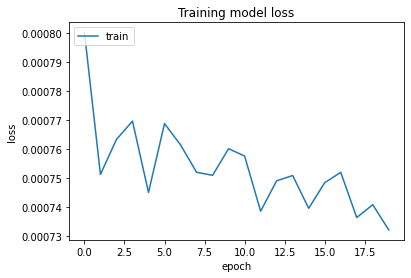

In [48]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [60]:
testData = pd.read_csv('/content/example_test_files/stock_prices.csv')
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce')
#testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values 
testData.head()
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
testData.shape
timestep = 60
for i in range(timestep,length):  
    X_test.append(inputClosing[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape




(3940, 60, 1)

In [61]:
y_pred = model.predict(X_test)
y_pred

array([[       nan],
       [       nan],
       [       nan],
       ...,
       [0.11037409],
       [0.11038097],
       [0.11036565]], dtype=float32)

In [62]:
predicted_price = sc.inverse_transform(y_pred)

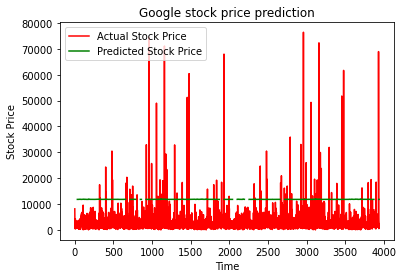

In [63]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()